In [ ]:
# References: https://github.com/Milind-Blaze/CS7015_2019/blob/cd502500f002c764a5832a19d40373854c886432/Assignment3/train.py#L668

In [145]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
def fetchDataset():
    # reading the datapoints and their labels
    featuresDataFrame = pd.read_csv('MNISTnumImages5000_balanced.txt', sep="\t", header=None)
    labelsDataFrame = pd.read_csv('MNISTnumLabels5000_balanced.txt', header=None)
    labelsDataFrame.columns = ['Class Label']
    # merging datapoints and labels into one dataframe
    fullDataFrame = pd.concat([featuresDataFrame, labelsDataFrame], axis=1)
    return fullDataFrame

In [3]:
def generateDigitsFiles(fullDataFrame):
    for i in range(0, 10):
        fileName = '%d\'s' % i
        # generating separate files for digits
        fullDataFrame[fullDataFrame['Class Label'] == i].to_csv(fileName, index=False)

In [4]:
fullDataFrame = fetchDataset()
generateDigitsFiles(fullDataFrame)

In [5]:
def toOneHot(labelVector, nvalues):
    output = np.eye(nvalues)[labelVector.reshape(-1)]
    return output.reshape(list(np.shape(labelVector)) + [nvalues])

In [6]:
def train_test_split():
    # fetching 400 points for each digit to make a training set and the remaining 100 to make a test set 
    train = np.empty((0, 785))
    test = np.empty((0, 785))
    for i in range(0, 10):
        df = pd.read_csv(f'{i}\'s', header=0)
        train = np.append(train, df.iloc[0:400].to_numpy(), axis = 0)    
        test = np.append(test, df.iloc[400:].to_numpy(), axis = 0)
    # Shuffling the data points to aid learning
    train = pd.DataFrame(train).sample(frac = 1).to_numpy()
    X_train = train[:, 0:-1]
    y_train = np.array([int(i) for i in train[:, -1]])
    y_train = toOneHot(y_train, 10)
    X_test = test[:, 0:-1]
    y_test = np.array([int(i) for i in test[:, -1]])
    y_test = toOneHot(y_test, 10)
    return X_train.T, X_test.T, y_train.T, y_test.T

In [7]:
X_train, X_test, y_train, y_test = train_test_split()
print(f'X_train: {X_train.shape}; {type(X_train)}')
print(f'X_test: {X_test.shape}; {type(X_test)}')
print(f'y_train: {y_train.shape}; {type(y_train)}')
print(f'y_test: {y_test.shape}; {type(y_test)}')

X_train: (784, 4000); <class 'numpy.ndarray'>
X_test: (784, 1000); <class 'numpy.ndarray'>
y_train: (10, 4000); <class 'numpy.ndarray'>
y_test: (10, 1000); <class 'numpy.ndarray'>


In [8]:
X_train[0].shape

(4000,)

In [71]:
# Setting important variables
activationFunction = 'sigmoid'
batchSize = 0 # trying to use the entire dataset now
epochs = 400
eta = 0.001
gamma = 0.4
lossFunc = 'squared error'
numHidden = 1
optimizer = 'gdm' # gradient descent with momentum for Assignment 4
sizes = [120] # sizes of hidden layers as an array

In [10]:
def createNetwork(inputsize, numHidden, outputsize, sizes):
    # sizes = [100] -- single hidden layer with 100 nuerons
    sizes = [inputsize] + sizes + [outputsize]
    np.random.seed(3567)
    parameters = {}
    for i in range(1, numHidden + 2):
        parameters['W' + str(i)] = np.random.randn(sizes[i], sizes[i - 1])
        parameters['b' + str(i)] = np.random.randn(sizes[i], 1)
    return parameters

In [11]:
def getGradients(inputsize, numHidden, outputsize, sizes):
    sizes = [inputsize] + sizes + [outputsize]
    # gradients wrt input layer; think of inputs as 784 h's and their a's
    gradients = {'dh0': np.zeros((inputsize, 1)), 'da0': np.zeros((inputsize, 1))}
    # gradients wrt to deeper layers; gradients with respect to output h; aggregation a; weights W; bias b
    for i in range(1, numHidden + 2):
        gradients['dW' + str(i)] = np.zeros((sizes[i], sizes[i-1]))
        gradients["db" + str(i)] = np.zeros((sizes[i],1))
        gradients["da" + str(i)] = np.zeros((sizes[i],1))
        gradients["dh" + str(i)] = np.zeros((sizes[i],1))
    return gradients

In [12]:
def getMoments(inputsize, numHidden, outputsize, sizes):
    sizes = [inputsize] + sizes + [outputsize]
    momentums = {}
    for i in range(1, numHidden + 2):
        momentums['momW' + str(i)] = np.zeros((sizes[i], sizes[i-1]))
        momentums["momb" + str(i)] = np.zeros((sizes[i],1))
    return momentums

In [13]:
def activate(z, activationFunction):
    if(activationFunction == 'sigmoid'):
        return sigmoid(z)

In [14]:
# Takes in aggregation vector (ak) arguments and gives out activation vector (hk) arguments
def sigmoid(z):
	return 1/(1 + np.exp(-z))

In [15]:
def softmax(z):
    z = z - np.max(z)
    numer = np.exp(z)
    denom = np.sum(numer, axis = 0) # softmax over each example seprately
    return numer/denom

In [16]:
def forwardPropagate(x, parameters, activationFunction, numHidden):
    # dict to store the results of aggregations
    A = {}
    # making this into a proper column vector as per AndrewNg's video (change from (5, ) to (5, 1))
    if x.ndim == 1:
        x = x[:, np.newaxis]
    # dict to store the results of activations
    H = {'h0': x}
    for k in range(1, numHidden + 2):
        Wk = parameters['W' + str(k)]
        bk = parameters['b' + str(k)]
        hprev = H['h' + str(k - 1)]
        ak = np.dot(Wk, hprev) + bk
        A['a' + str(k)] = ak
        if (k != numHidden + 1):
            hk = activate(ak, activationFunction)
        if (k == numHidden + 1):
            # apply softmax on the last layer
            hk = softmax(ak)
        H['h' + str(k)] = hk
    yhat = H['h' + str(numHidden + 1)]
    # this function returns the predicted output vector yhat, aggregation vectors at each layer A, and
    #activations vector at each layer H
    return yhat, A, H

In [17]:
def sigmoidGradient(deltalArray):
    # sigmoid gradient is f(x) * (1 - f(x))
    return sigmoid(deltalArray) * (1 - sigmoid(deltalArray))

In [18]:
# backpropagation is 3 steps. Gradients wrt to output layer; Gradients wrt to any random layer; Gradients wrt to weights and biases
# Sequence: Loss function -> Output -> Aggregation in Output -> Weights & Biases in Output -> 
# -> Output from L-1 -> Aggregation in L-1 -> Weights and biases in L-1 ->........-> Input Layer
def backPropagate(H, A, parameters, numHidden, sizes, y, yhat, lossFunc, activationFunction, inputsize, outputsize):
    # gradients with respect to output layer - like LMS
    # think of gradSimulate as the simulation of gradients each time this method is called
    gradSimulate = getGradients(inputsize, numHidden, outputsize, sizes)
    # remember A is the fwd prop result of our network
    A['a0'] = np.zeros((inputsize, 1))
    # AndrewNg - normalize as column vectors for y and yhat even though yhat is already a column vector
    if y.ndim == 1:
        y = y[:, np.newaxis]
    if yhat.ndim == 1:
        yhat = yhat[:, np.newaxis]
    if (lossFunc == 'squared error'):
        # Notes to self: refer to derivation from diary (Achieved via backtracking)
        gradSimulate['da' + str(numHidden + 1)] = (yhat - y) * yhat - yhat * (np.dot((yhat - y).T, yhat))
    for i in np.arange(numHidden + 1, 0, -1):
        # Gradients wrt to output layer calculated outside the loop
        gradSimulate['dW' + str(i)] = np.dot(gradSimulate["da" + str(i)], (H["h" + str(i-1)]).T)
        gradSimulate["db" + str(i)] = gradSimulate["da" + str(i)]
        gradSimulate["dh" + str(i - 1)] = np.dot((parameters["W" + str(i)]).T, gradSimulate["da" + str(i)])
        
        # potential to implement more activation functions here
        if activationFunction == 'sigmoid':
            deltal = sigmoidGradient(A['a' + str(i - 1)])
        gradSimulate['da' + str(i - 1)] = gradSimulate["dh" + str(i - 1)] * deltal
    return gradSimulate

In [28]:
def calcAccuracy(YhatTrain, y_train):
    a = np.argmax(YhatTrain, axis = 0)
    #print((a.shape))
    b = np.argmax(y_train, axis = 0)
    return (np.sum(a == b) / len(a))

In [29]:
def calcErrorFracion(YhatTrain, y_train):
    a = np.argmax(YhatTrain, axis = 0)
    #print((a.shape))
    b = np.argmax(y_train, axis = 0)
    return (np.sum(a != b) / len(a))

In [20]:
def squaredError(YhatTrain, y_train):
    x = np.array(YhatTrain)
    y = np.array(y_train)
    if x.ndim == 1:
        x = x[:, np.newaxis]
    if y.ndim == 1:
        y = y[:, np.newaxis]
    loss = 0.5 * np.sum((y - x) ** 2)
    return loss

In [35]:
def calculateMetrics(X_train, X_test, y_train, y_test, parameters, activationFunction, numHidden, lossFunc):
    # fwd pass all train data set at once
    YhatTrain, _, _ = forwardPropagate(X_train, parameters, activationFunction, numHidden)
    trainingerrorFraction = calcErrorFracion(YhatTrain, y_train)
    trainingAccuracy = calcAccuracy(YhatTrain, y_train)
    trainErrorLoss = squaredError(YhatTrain, y_train)
    # fwd pass all test data set at once
    YhatTest, _, _ = forwardPropagate(X_test, parameters, activationFunction, numHidden)
    testerrorFraction = calcErrorFracion(YhatTest, y_test)
    testAccuracy = calcAccuracy(YhatTest, y_test)
    testErrorLoss = squaredError(YhatTest, y_test)
    return trainingerrorFraction, trainingAccuracy, trainErrorLoss, testerrorFraction, testAccuracy, testErrorLoss

In [72]:
def momgd(X_train, y_train, activationFunction, batchSize, epochs, eta, gamma, 
        lossFunc, numHidden, optimizer, sizes, inputsize = 784, outputsize = 10):
    print("momentum based gradient descent")

    epochData = []

    parameters = createNetwork(inputsize, numHidden, outputsize, sizes)
    prevMoments = getMoments(inputsize, numHidden, outputsize, sizes)
    currMoments = getMoments(inputsize, numHidden, outputsize, sizes)
    epoch = 0
    # Errorfractions before training begun
    trainingerrorFraction, trainingAccuracy, trainErrorLoss, testerrorFraction, testAccuracy, testErrorLoss = calculateMetrics(X_train, X_test, y_train, y_test, parameters, activationFunction, numHidden, lossFunc)
    epochData.append([-1, trainingerrorFraction, trainingAccuracy, trainErrorLoss, testerrorFraction, testAccuracy, testErrorLoss])
    while epoch < epochs:
        # accumulate gradients over the epoch
        gradients = getGradients(inputsize, numHidden, outputsize, sizes)
        # iterate through datapoints
        for i in range(0, 4000):
            x = X_train[:, i]
            y = y_train[:, i]
            # perform forward propagation
            yhat, A, H = forwardPropagate(x, parameters, activationFunction, numHidden)
            #print(f'yhat is \n {yhat} \n shape is {yhat.shape} \n ndim is {yhat.ndim}')
            # compute gradients for each training example - Stochastic gradient descent
            newGradients = backPropagate(H, A, parameters, numHidden, sizes, y, yhat, lossFunc, activationFunction, inputsize, outputsize)
            for key in gradients:
                gradients[key] = gradients[key] + newGradients[key]
        for layer in parameters:
                currMoments['mom' + layer] = (gamma * prevMoments['mom' + layer]) + (eta * (gradients['d' + layer]))
                parameters[layer] = parameters[layer] - currMoments['mom' + layer]
                prevMoments['mom' + layer] = currMoments['mom' + layer]
        print(f'epoch {epoch} completed')
        # record epoch metrics
        trainingerrorFraction, trainingAccuracy, trainErrorLoss, testerrorFraction, testAccuracy, testErrorLoss = calculateMetrics(X_train, X_test, y_train, y_test, parameters, activationFunction, numHidden, lossFunc)
        epochData.append([epoch, trainingerrorFraction, trainingAccuracy, trainErrorLoss, testerrorFraction, testAccuracy, testErrorLoss])
        epoch = epoch + 1
    return parameters, epochData

In [87]:
def saveParams(parameters, savePath):
    try:
        os.mkdir(savePath)
        print('directory created')
    except FileExistsError:
        print('directory exists')
    fileName = savePath + 'weights&biases' + '.pickle'
    with open(fileName, 'wb') as handle:
        pickle.dump(parameters, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [73]:
# transpose doesnt matter for a single data point but will be valuable when passing the whole dataset. 
#Our code can use the transposed dataset and calculate the training set at one go
parameters, epochData = momgd(X_train, y_train, activationFunction, batchSize, epochs, eta, 
                                    gamma, lossFunc, numHidden, optimizer, sizes)

momentum based gradient descent
epoch 0 completed
epoch 1 completed
epoch 2 completed
epoch 3 completed
epoch 4 completed
epoch 5 completed
epoch 6 completed
epoch 7 completed
epoch 8 completed
epoch 9 completed
epoch 10 completed
epoch 11 completed
epoch 12 completed
epoch 13 completed
epoch 14 completed
epoch 15 completed
epoch 16 completed
epoch 17 completed
epoch 18 completed
epoch 19 completed
epoch 20 completed
epoch 21 completed
epoch 22 completed
epoch 23 completed
epoch 24 completed
epoch 25 completed
epoch 26 completed
epoch 27 completed
epoch 28 completed
epoch 29 completed
epoch 30 completed
epoch 31 completed
epoch 32 completed
epoch 33 completed
epoch 34 completed
epoch 35 completed
epoch 36 completed
epoch 37 completed
epoch 38 completed
epoch 39 completed
epoch 40 completed
epoch 41 completed
epoch 42 completed
epoch 43 completed
epoch 44 completed
epoch 45 completed
epoch 46 completed
epoch 47 completed
epoch 48 completed
epoch 49 completed
epoch 50 completed
epoch 51 

In [76]:
epochResults = pd.DataFrame(epochData, columns = ['Epoch', 'Training Error Fraction', 'Training Accuracy', 'Train Error Loss', 'Test Error Fraction', 'Test Accuracy', 'Test Error Loss'])

In [91]:
epochResults

,Epoch,Training Error Fraction,Training Accuracy,Train Error Loss,Test Error Fraction,Test Accuracy,Test Error Loss
0,-1,0.89775,0.10225,3528.968427,0.902,0.098,884.685229
1,0,0.89700,0.10300,3481.010355,0.903,0.097,874.821164
2,1,0.89050,0.10950,3352.225079,0.898,0.102,838.272777
3,2,0.88775,0.11225,3186.134401,0.887,0.113,798.541523
4,3,0.87000,0.13000,3082.626368,0.886,0.114,783.884816
...,...,...,...,...,...,...,...
396,395,0.28000,0.72000,808.477846,0.385,0.615,290.196628
397,396,0.28000,0.72000,807.362548,0.385,0.615,289.846928
398,397,0.27925,0.72075,806.265888,0.381,0.619,289.648303
399,398,0.27950,0.72050,805.171492,0.384,0.616,289.304554


In [90]:
saveParams(parameters, 'D:\\IS\\')

directory created


In [130]:
def plotErrorFraction():
    # create a figure
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    # add data
    graphEpochs = np.arange(-1, epochs, 1)
    graphTrainEF = np.array(epochResults['Training Error Fraction'])
    graphTestEF = np.array(epochResults['Test Error Fraction'])
    ax.plot(graphEpochs, graphTrainEF, label = "Training Set Error Fraction")
    ax.plot(graphEpochs, graphTestEF, label = "Testing Set Error Fraction")
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Error Fraction')
    ax.set_title('Epochs vs. Error Fraction for Training & Test Datasets')
    ax.legend()
    fig.figure

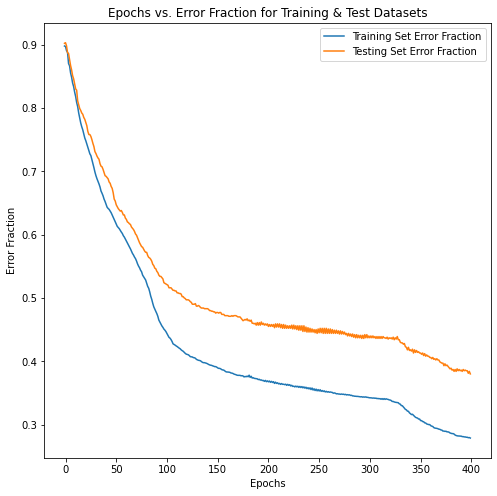

In [131]:
plotErrorFraction()

In [132]:
parameters

{'W1': array([[-0.24777472,  0.64296983,  0.60064666, ...,  0.25029411,
         -0.00244166,  0.7851877 ],
        [-0.3010106 , -1.02191629, -0.4692708 , ...,  0.33271858,
         -1.01523648, -0.22059072],
        [ 0.60976048,  1.28001673, -0.82831761, ...,  0.72231067,
         -0.14594454, -1.21948186],
        ...,
        [ 0.77498335, -2.24399172, -1.36744067, ..., -0.72383207,
         -1.05535895, -1.35885259],
        [-1.48498213,  1.02461396, -1.20376074, ..., -0.28033733,
         -0.30247997,  0.94755103],
        [ 0.22725326, -0.45469509, -0.96331526, ...,  0.03136295,
         -1.68112667, -1.48472036]]),
 'b1': array([[ 6.42780081e-01],
        [ 1.22833460e+00],
        [-1.79713658e+00],
        [ 1.00697682e+00],
        [-1.07550015e-01],
        [-1.32827423e+00],
        [-5.56971956e-01],
        [ 3.58678401e-01],
        [ 5.73469427e-01],
        [ 1.10980058e+00],
        [ 1.77848492e+00],
        [-1.03804658e+00],
        [-8.70436362e-01],
        [ 

In [133]:
def getPredVectors(Yhat, y):
    a = np.argmax(Yhat, axis = 0)
    #print((a.shape))
    b = np.argmax(y, axis = 0)
    return a, b

In [136]:
def finalPredictions(X_train, X_test, y_train, y_test, parameters, activationFunction, numHidden):
    YhatTrain, _, _ = forwardPropagate(X_train, parameters, activationFunction, numHidden)
    trainPredictionVector, trainActualVector = getPredVectors(YhatTrain, y_train)
    YhatTest, _, _ = forwardPropagate(X_test, parameters, activationFunction, numHidden)
    testPredictionVector, testActualVector = getPredVectors(YhatTest, y_test)
    return trainPredictionVector, trainActualVector, testPredictionVector, testActualVector

In [137]:
trainPredictionVector, trainActualVector, testPredictionVector, testActualVector = finalPredictions(X_train, X_test, y_train, y_test, parameters, activationFunction, numHidden)

In [187]:
# setting up dataframes for predictions
# training predictions
training = pd.DataFrame(columns = ['Train Actual Label', 'Train Predicted Label'])
training['Train Actual Label'] = trainActualVector
training['Train Predicted Label'] = trainPredictionVector
# test predictions
testing = pd.DataFrame(columns = ['Test Actual Label', 'Test Predicted Label'])
testing['Test Actual Label'] = testActualVector
testing['Test Predicted Label'] = testPredictionVector

In [189]:
def getConfusionMatrix(dataset, actualLabelColumn, predictedLabelColumn, classSize):
    confusionMatrix = np.zeros((classSize, classSize))
    for i in range(0, classSize):
        actualRow = dataset[dataset[actualLabelColumn] == i][predictedLabelColumn].value_counts()
        for j in actualRow.index:
            confusionMatrix[i][j] = actualRow[j]
    return confusionMatrix

In [190]:
trainingConfusionMatrix = getConfusionMatrix(training, 'Train Actual Label', 'Train Predicted Label', 10)
testConfusionMatrix = getConfusionMatrix(testing, 'Test Actual Label', 'Test Predicted Label', 10)

In [212]:
#references: https://vitalflux.com/python-draw-confusion-matrix-matplotlib/
def plotConfusionMatrix(conf_matrix, dsType):
    fig2, ax1 = plt.subplots(figsize=(10, 10))
    ax1.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax1.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    ax1.set_xlabel('Predictions', fontsize = 18)
    ax1.set_ylabel('Actual', fontsize = 18)
    ax1.set_xticks(np.arange(0, 10))
    ax1.set_yticks(np.arange(0, 10))
    ax1.set_ylabel('Actual')
    ax1.set_title(f'Confusion Matrix for {dsType} Dataset')
    fig2.figure

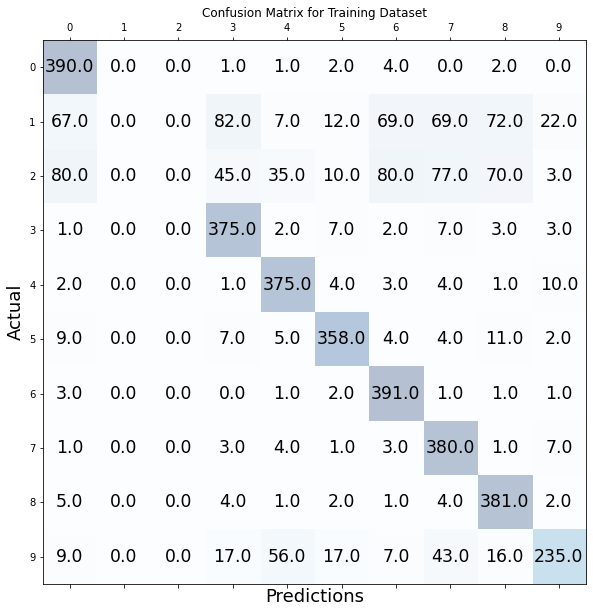

In [214]:
plotConfusionMatrix(trainingConfusionMatrix, 'Training')

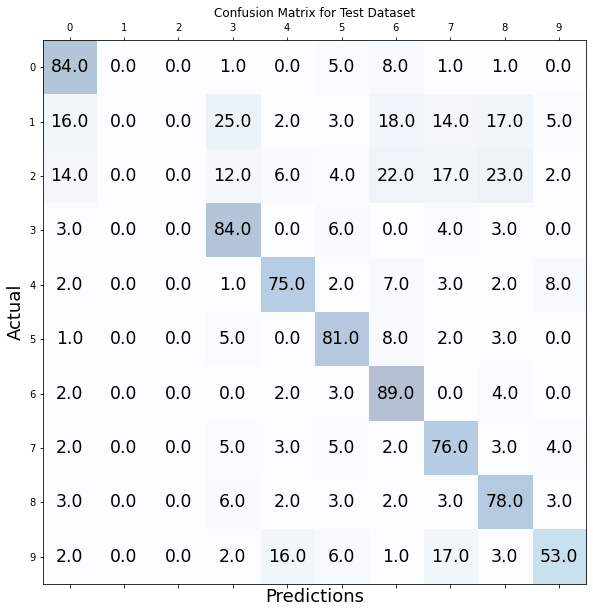

In [213]:
plotConfusionMatrix(testConfusionMatrix, 'Test')